In [8]:
%pylab inline
import kwant
print(kwant.__version__)

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

from jupyterthemes import jtplot
#jtplot.style()

Populating the interactive namespace from numpy and matplotlib
1.4.1


/Users/nagydaniel/miniconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['sys']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


The vector potential enters in the tight-binding model as a so-called Peierls-phase,
where we replace a hopping $t_{ij}$ as

$$t_{ij} \rightarrow t_{ij} \times \exp\left(i \frac{e}{\hbar} \int_{\mathbf{x}_j}^{\mathbf{x}_i} \mathbf{A}(\mathbf{x}) d\mathbf{s}\right)$$

For our 2D square lattice model this is easy to solve, and we find that all hoppings
must be multiplied with a phase

$$\exp\left(i\, \frac{e}{\hbar} B \frac{(y_i + y_j)}{2} (x_i-x_j)\right)$$

Note that we can rewrite this as 

$$
\exp\left(i\, 2 \pi \frac{\phi}{\phi_0} \frac{(y_i + y_j)(x_i-x_j)}{2a^2} \right)
$$

where $\phi = B a^2$ is the flux through a unit cell in the square lattice, and $\phi_0 = h/e$ the flux quantum.l

In [25]:
# configuration
a = 1
t = -1.0

V_L = -0.2*t
V_S = -0.2*t

w_constriction = 5
l_constriction = 10

w_lead = 20
l_lead = 4

energy = 1.5
phis = np.linspace(0, 1.1, 100)

In [26]:
def make_qpc():  
  lat = kwant.lattice.square(a)
  syst = kwant.Builder()
  
  # A shape can be defined using a function, that returns True, if a point is
  # inside the shape, False otherwise
  def shape1(pos):
    x,y = pos
    return abs(x) < l_constriction and abs(y) < w_constriction

  def shape2(pos):
    x,y = pos
    return (l_constriction <= abs(x) < l_constriction + l_lead) and abs(y) < w_lead 

  # Doc: https://kwant-project.org/doc/1/reference/generated/kwant.lattice.Polyatomic#kwant.lattice.Polyatomic.shape
  syst[lat.shape(function=shape1, start=(0,0))] = V_S
  syst[lat.shape(function=shape2, start=(l_constriction,0))] = V_S
  syst[lat.shape(function=shape2, start=(-l_constriction,0))] = V_S

  # Define a hopping function:
  def hopping(site_i, site_j, phi):
    xi, yi = site_i.pos
    xj, yj = site_j.pos
    return -exp( -0.5j * phi * (xi - xj) * (yi + yj) )
  
  # Adding hoppings to the lattice:
  syst[lat.neighbors()] = hopping

  # Attach leads to the system
  def lead_shape(pos):
    x,y = pos
    return (-w_lead < y < w_lead)
  
  lead_sym = kwant.TranslationalSymmetry((-a, 0))
  lead = kwant.Builder(lead_sym)

  lead[lat.shape(lead_shape, (0,0))] = V_L
  lead[lat.neighbors()] = t

  syst.attach_lead(lead)
  syst.attach_lead(lead.reversed())
  return syst

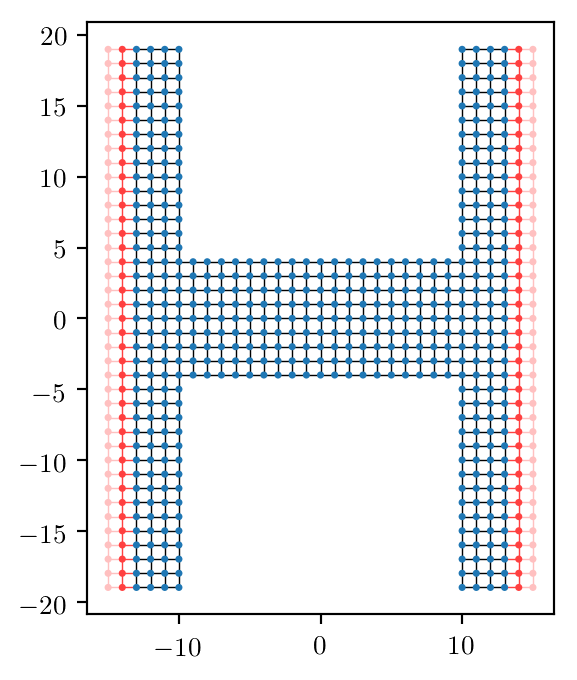

In [27]:
qpc = make_qpc()
fig = kwant.plot(qpc, dpi=196);
fig.savefig("qpc_L{0}_W{1}.png".format(l_constriction, w_constriction), dpi=196)

In [28]:
sys = qpc.finalized()

c = []
for phi in phis:
  smatrix = kwant.smatrix(sys, energy=energy, params=dict(phi=phi))
  c.append(smatrix.transmission(0,1))

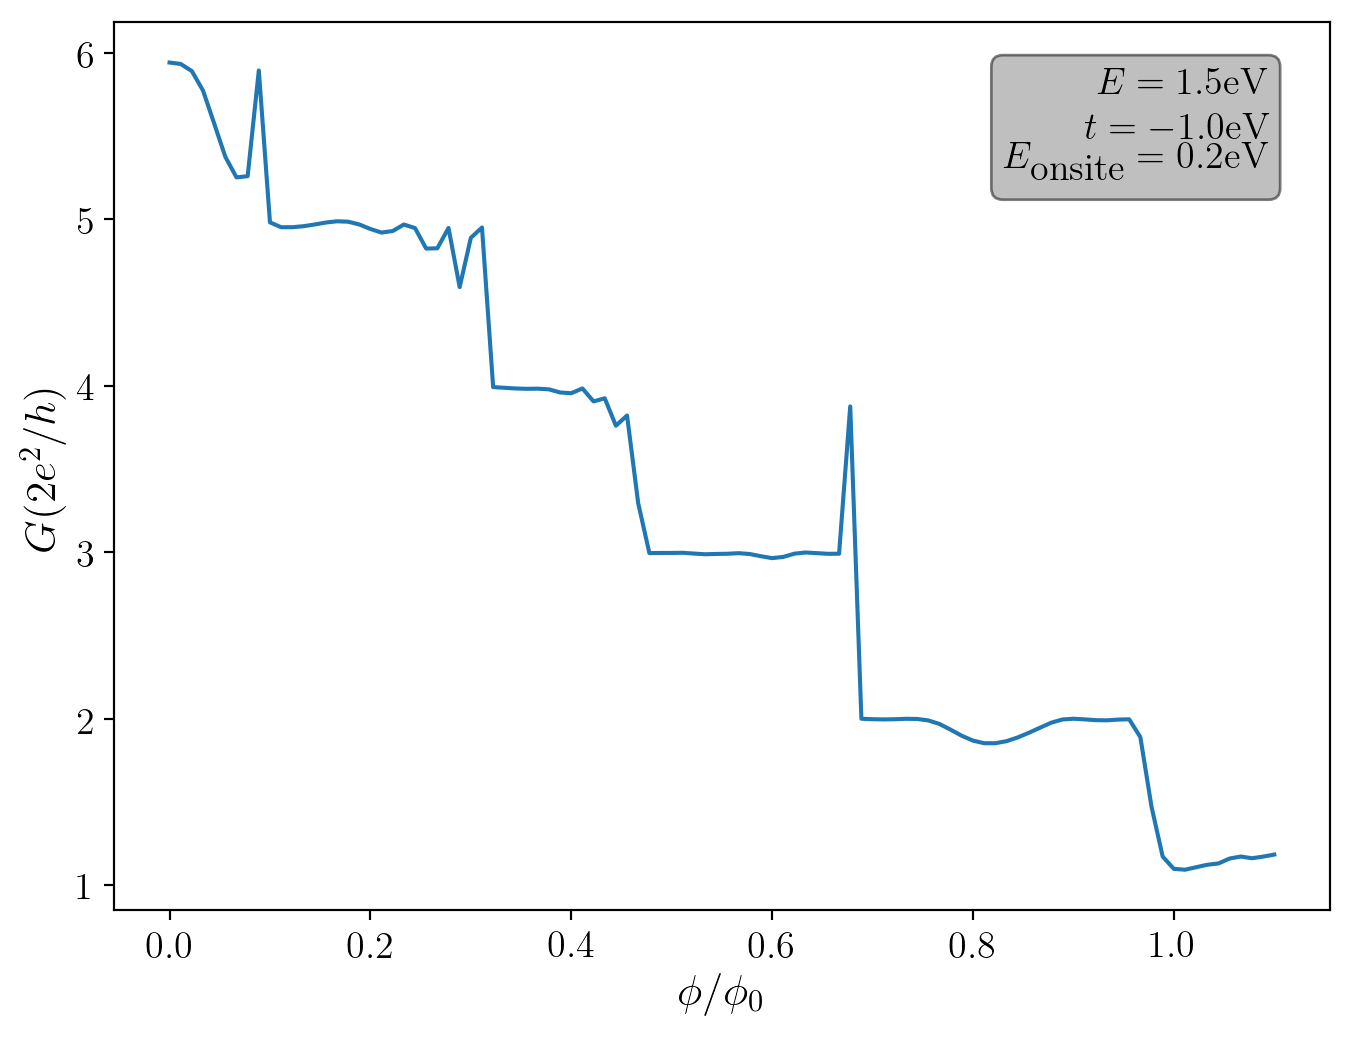

In [29]:
fig, ax = plt.subplots(figsize=(8,6), dpi=196)

ax.set_xlabel(r"$\phi/\phi_0$", fontsize=16)
ax.set_ylabel(r"$G (2e^2/h)$", fontsize=16)
ax.plot(phis, c, '-')

textstr = '\n'.join((
    r'$E={}'.format(energy) + r'\textnormal{eV}$',
    r'$t={}'.format(t) + r'\textnormal{eV}$',
    r'$E_{\textnormal{onsite}}='+ '{}'.format(V_S) + r'\textnormal{eV}$'))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='grey', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.95, 0.95, textstr,
        transform=ax.transAxes,
        fontsize=14,
        verticalalignment='top',
        horizontalalignment='right', bbox=props)

ax.tick_params(axis='both', which='major', labelsize=14)
plt.savefig("qpc_L{0}_W{1}_VS{2}_cond_phi_e{3}.png".format(l_constriction,
                                                     w_constriction,
                                                     "_".join(str(V_S).split(".")),
                                                     "_".join(str(energy).split("."))),
            dpi=196)